In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [4]:
def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

In [5]:
def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

In [28]:
def run_single(X_train, X_test, y_train, y_test, random_state=0):
    eta = 0.1
    max_depth= 6 
    subsample = 1
    colsample_bytree = 1
    min_chil_weight=1
    start_time = time.time()
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        #"num_class" : 22,
    }
    num_boost_round = 500
    early_stopping_rounds = 100
    test_size = 0.1
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index))
    print('Length valid:', len(X_valid.index))
    dtrain = xgb.DMatrix(X_train, y_train, missing=-99)
    dvalid = xgb.DMatrix(X_valid, y_valid, missing =-99)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(y_valid, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    print('Importance array: ', imp)

    print("Predict test set... ")
    test_prediction = gbm.predict(xgb.DMatrix(X_test,missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_test, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
    

 
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################
    
    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    # gbm.best_iteration+1
    return test_prediction, imp, gbm


In [7]:
df_label = pd.read_parquet("data/bookingID.parquet")

In [9]:
df_feature = pd.read_parquet("data/features.parquet")

In [11]:
# Inspect label and feature shape
print(df_label.shape)
print(df_feature.shape)
assert df_label.shape[0] == df_feature.shape[0]

(19863, 3)
(19863, 100)


In [14]:
X = df_feature

In [13]:
# take only label 0 and 1
y = df_label['label'].values

In [15]:
# split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
# inspect class imbalance
pd.DataFrame(y_train, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0.0,11908
1,1.0,3982


In [17]:
# inspect class imbalance
pd.DataFrame(y_test, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0.0,3004
1,1.0,969


Start time:  2019-06-15 09:17:09.807217
XGBoost params. ETA: 0.1, MAX_DEPTH: 6, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Length train: 14301
Length valid: 1589
[0]	train-auc:0.639865	eval-auc:0.624656
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.65777	eval-auc:0.626878
[2]	train-auc:0.680296	eval-auc:0.638612
[3]	train-auc:0.688243	eval-auc:0.643414
[4]	train-auc:0.69238	eval-auc:0.641173
[5]	train-auc:0.693871	eval-auc:0.643079
[6]	train-auc:0.712885	eval-auc:0.643903
[7]	train-auc:0.724283	eval-auc:0.647801
[8]	train-auc:0.729118	eval-auc:0.646106
[9]	train-auc:0.742772	eval-auc:0.64659
[10]	train-auc:0.747004	eval-auc:0.644039
[11]	train-auc:0.751632	eval-auc:0.644718
[12]	train-auc:0.758176	eval-auc:0.65075
[13]	train-auc:0.771305	eval-auc:0.653253
[14]	train-auc:0.779048	eval-auc:0.657653
[15]	train-auc:0.783402	eval-auc:0.657101
[16]	train-auc:0.789279	eval-auc:0.653891
[17]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


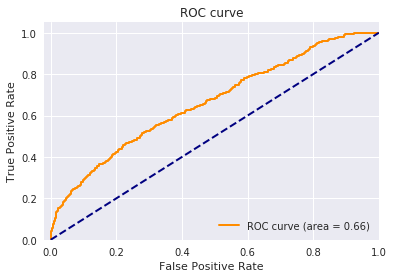

Training time: 0.09 minutes
0:00:05.670164
CPU times: user 42 s, sys: 657 ms, total: 42.6 s
Wall time: 5.67 s


In [29]:
%%time
start_time = dt.datetime.now()
print("Start time: ",start_time)
preds, imp, model = run_single(X_train, X_test, y_train, y_test,42)
print(dt.datetime.now()-start_time)